In [86]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from monai.transforms import Activations
from monai.metrics import ROCAUCMetric

from sklearn.metrics import ConfusionMatrixDisplay#, confusion_matrix 
from sklearn import metrics
import sklearn

import misc


In [2]:
def get_predictions_filename(folder_name):
    if "dcnn_lrelu" in folder_name:
        fold_test_preds_filename = "dcnn_lrelu_outputs.csv"
        ens_test_preds_filename = "dcnn_lrelu_ens_outputs.csv"
        #print('hi')

    return fold_test_preds_filename, ens_test_preds_filename



softmax_act = Activations(softmax=True)
auc_metric = ROCAUCMetric()

In [236]:
from torcheval.metrics import MulticlassAUROC, BinaryAUROC, BinaryF1Score, BinaryConfusionMatrix, BinaryAUPRC, BinaryRecall
from torcheval.metrics.functional.classification import binary_recall


def collect_metrics(targets, predictions, thresh = 0.5, verbose = False):
    # make the predictions binary, by thresholding the predicted probabilities
    preds_binary = torch.round(torch.tensor([1 if p > thresh else 0 for p in predictions])).type(torch.int)

    """
    # precision
    precision_metric = BinaryAUPRC() 
    precision_metric.update(input=preds_binary, target=targets)
    precision_score = precision_metric.compute()
    precision_metric.reset()

    # recall
    recall_metric = BinaryRecall()
    recall_metric.update(input=preds_binary, target=targets)
    recall_score = recall_metric.compute()
    recall_metric.reset()

    # F1-score
    f1_metric = BinaryF1Score()
    f1_metric.update(input=preds_binary, target=targets)
    f1_score = f1_metric.compute()
    f1_metric.reset()
    """

    # AUC
    auc_metric = BinaryAUROC()
    auc_metric.update(input=predictions, target=targets)
    auc_score = auc_metric.compute()
    auc_metric.reset()


    CM = BinaryConfusionMatrix()
    CM.update(input=preds_binary, target=targets)
    cm = CM.compute()
    CM.reset()

    TN = int(cm[0,0].item())
    FP = int(cm[0,1].item())
    FN = int(cm[1,0].item())
    TP = int(cm[1,1].item())

    accuracy_score = (TP + TN) / (TP + TN + FP + FN)
    precision_score = TP / (TP + FP)
    recall_score = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1_score = (2 * precision_score * recall_score) / (precision_score + recall_score)

    
    if verbose:
        print(f"  accuracy score:      {accuracy_score:.3f}")
        print(f"  precision score:     {precision_score:.3f}")
        print(f"  recall score:        {recall_score:.3f}")
        print(f"  specificity score:   {specificity:.3f}")

        print(f"  f1 score:            {f1_score:.3f}")
        print(f"  AUC score:           {auc_score:.3f}")
        print("  Confusion Matrix:   ")
        print(cm)
        print(" ")
    

    return accuracy_score, precision_score, recall_score, specificity, f1_score, auc_score, cm


FOLD 0
  accuracy score:      0.645
  precision score:     0.500
  recall score:        0.041
  specificity score:   0.978
  f1 score:            0.075
  AUC score:           0.770
  Confusion Matrix:   
tensor([[87.,  2.],
        [47.,  2.]])
 
FOLD 1
  accuracy score:      0.674
  precision score:     0.538
  recall score:        0.571
  specificity score:   0.730
  f1 score:            0.554
  AUC score:           0.756
  Confusion Matrix:   
tensor([[65., 24.],
        [21., 28.]])
 
FOLD 2
  accuracy score:      0.732
  precision score:     0.676
  recall score:        0.469
  specificity score:   0.876
  f1 score:            0.554
  AUC score:           0.752
  Confusion Matrix:   
tensor([[78., 11.],
        [26., 23.]])
 
FOLD 3
  accuracy score:      0.696
  precision score:     0.630
  recall score:        0.347
  specificity score:   0.888
  f1 score:            0.447
  AUC score:           0.752
  Confusion Matrix:   
tensor([[79., 10.],
        [32., 17.]])
 
FOLD 4
  acc

[]

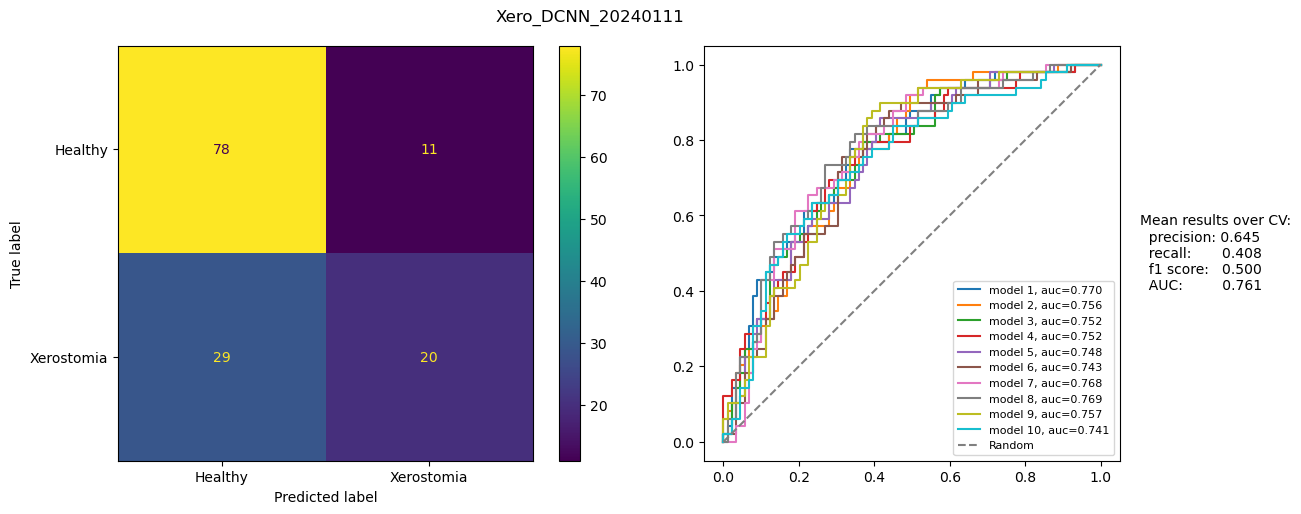

In [238]:
root = "experiments"

df_results = pd.DataFrame(columns=["exp_name", ""])

experiment_name = "Xero_DCNN_BinaryOutput_20240111"
experiment_name="Xero_DCNN_20240111"
#experiment_name='xero_no_baseline'
#experiment_name='xero_no_clinical'


folder_path = os.path.join(root, experiment_name)

cv_fold_folders = next(os.walk(folder_path))[1] # find all subfolders (each subfolder is a cv fold)


avg_precision_score, avg_recall_score, avg_f1_score, avg_auc_score, avg_cm = 0,0,0,0, torch.tensor([[0,0],[0,0]]).type(torch.float)
ens_predictions = None


verbose = True


folds = len(cv_fold_folders)


fig, ax = plt.subplots(1, 2, figsize=(12,5), gridspec_kw={'width_ratios': [1, 1]})

for idx, cv_folder_name in enumerate(cv_fold_folders):
    if verbose:    print(f"FOLD {idx}")
    # make the filenames
    fold_test_preds_filename, ens_test_preds_filename = get_predictions_filename(cv_folder_name)

    preds_file_dir = os.path.join(os.path.join(folder_path, cv_folder_name), fold_test_preds_filename)

    # open the predictions file, get the predictions and true labels out
    df_preds = pd.read_csv(preds_file_dir, delimiter=";")
    preds= list(df_preds['pred_1'])
    y_true = list(df_preds['true_1'])  # again just the second col

    try:
        if ens_predictions == None: 
            ens_predictions = preds
        else: ens_predictions = np.add(ens_predictions, preds)
    except:
        ens_predictions = np.add(ens_predictions, preds)
    
    
    
    #preds_second_col = list(df_preds['pred_1'])  # the column of just the xero=yes column
    
    #y_true = [list(row) for row in zip(df_preds['true_0'], df_preds['true_1'])]
    


    # calculate fpr, fpr, auc, and plot it
    fpr, tpr, thresh = metrics.roc_curve(y_true, preds)  
    auc_score = metrics.roc_auc_score(y_true, preds)
    ax[1].plot(fpr, tpr, label=f"model {idx+1}, auc={auc_score:.3f}")


    targets_binarised =torch.tensor(y_true).type(torch.int)
    tensor_preds_single_col = torch.tensor(preds).type(torch.float)
    

    accuracy_score, precision_score, recall_score, specificity_score, f1_score, auc_score, cm = collect_metrics(targets_binarised, tensor_preds_single_col, thresh=0.5, verbose=verbose)

    avg_precision_score += precision_score /folds
    avg_recall_score += recall_score/folds
    avg_f1_score += f1_score/folds
    avg_auc_score += auc_score/folds
    avg_cm += cm/folds
    
    #print(cm)
    
    

    #plt.figure(1)
    #plt.plot(tpr, fpr, label=f"AAAHHH {idx}, auc={auc_score:.2f}")


#print("MEAN RESULTS")
"""
print(f"  precision score: {avg_precision_score:.3f}")
print(f"  recall score:    {avg_recall_score:.3f}")
print(f"  f1 score:        {avg_f1_score:.3f}")
print(f"  AUC score:       {avg_auc_score:.3f}")
print("  Confusion Matrix:   ")
print(avg_cm)
"""


ens_predictions = ens_predictions/10  # average the ensemble preds

ens_accuracy, ens_precision, ens_recall, ens_specificity, ens_F1, ens_AUC, ens_cm = collect_metrics(targets_binarised, torch.tensor(ens_predictions), thresh=0.5, verbose=verbose)


ConfusionMatrixDisplay(confusion_matrix=np.array(ens_cm.tolist()),
                               display_labels=["Healthy", "Xerostomia"]).plot(ax=ax[0])
#disp.plot()
display_string = f"Mean results over CV:\n  precision: {ens_precision:.3f}\n  recall:       {ens_recall:.3f}\n  f1 score:   {ens_F1:.3f}\n  AUC:         {ens_AUC:.3f}"

fig.text(1.05, 0.5, display_string, horizontalalignment='left', verticalalignment='center', transform=ax[1].transAxes)

ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
# fpr, tpr, thresh = metrics.roc_curve(y_true_binary, list(df_preds['pred_1']))
# auc = metrics.roc_auc_score(y_true_binary, list(df_preds['pred_1']))
# 
fig.suptitle(experiment_name)
ax[1].legend(loc='lower right', prop={'size': 8})
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
plt.tight_layout()
plt.plot()

In [233]:
ens_predictions

array([5.79192373, 3.29149398, 4.38651706, 2.79960955, 5.27292317,
       3.84761927, 1.68065341, 1.71967896, 2.85958648, 3.73552457,
       3.13866384, 0.93110103, 5.73264054, 4.63372645, 3.04409961,
       5.18247033, 4.196702  , 5.65130341, 1.97648842, 1.00020838,
       3.26575995, 4.54280158, 0.87664889, 2.7625875 , 5.49038159,
       2.72741724, 4.33178017, 4.07384445, 2.42670079, 3.76992196,
       5.95622099, 1.65553196, 3.96808167, 2.1394743 , 1.54697539,
       3.11230463, 1.50164471, 4.9097571 , 3.82326447, 4.21287082,
       5.54968807, 4.03658309, 3.94354015, 1.85581243, 3.82251601,
       5.36529905, 5.15206426, 5.94854256, 3.66386053, 4.86026702,
       3.13893218, 4.95918652, 4.76260038, 5.27318833, 4.35225223,
       0.93547106, 4.2928564 , 5.87029427, 5.56534959, 3.60906063,
       1.17129941, 3.55992374, 0.92462646, 3.21054661, 1.94380833,
       5.73406499, 1.45232591, 2.80696089, 1.92378005, 3.92883311,
       5.49443203, 5.65138325, 1.55869458, 3.99809721, 3.98695

In [80]:
ens_predictions = ens_predictions/10
collect_metrics(targets_binarised, torch.tensor(ens_predictions) )

  precision score: 0.584
  recall score:    0.408
  f1 score:        0.500
  AUC score:       0.761
  Confusion Matrix:   
tensor([[78., 11.],
        [29., 20.]])


[tensor(0.5839),
 tensor(0.4082),
 tensor(0.5000),
 tensor(0.7613, dtype=torch.float64),
 tensor([[78., 11.],
         [29., 20.]])]

In [66]:
len(ens_predictions)

1380

In [85]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from scipy.stats import norm

def calculate_overall_auc_ci(all_model_predictions, targets, n_bootstrap_samples=10000, confidence_level=0.95):
    # Concatenate predictions from all models into a 2D array
    #all_model_predictions = np.vstack(predictions_list).T

    # Calculate the AUC for the original data
    original_auc = roc_auc_score(targets, all_model_predictions)

    # Bootstrap resampling to get a distribution of AUC values
    auc_values = []
    for _ in range(n_bootstrap_samples):
        bootstrap_indices = resample(range(len(targets)), replace=True)
        bootstrap_auc = roc_auc_score(targets[bootstrap_indices], all_model_predictions[bootstrap_indices])
        auc_values.append(bootstrap_auc)

    # Calculate mean and standard error of the bootstrap AUC values
    mean_auc = np.mean(auc_values)
    std_auc = np.std(auc_values)

    # Calculate confidence interval using the normal distribution
    z_value = norm.ppf((1 + confidence_level) / 2)
    lower_bound = mean_auc - z_value * std_auc
    upper_bound = mean_auc + z_value * std_auc

    return {
        'original_auc': original_auc,
        'mean_auc': mean_auc,
        'confidence_interval': (lower_bound, upper_bound)
    }

# Example usage:
# predictions_list is a list of 1D lists, each representing the predictions from a different model
# targets is the 1D list of binary targets
# Ensure that all lists have the same length
# Replace these lists with your actual data
predictions_list = ens_predictions
targets = targets_binarised

result = calculate_overall_auc_ci(predictions_list, targets)
print("Original AUC:", result['original_auc'])
print("Mean AUC:", result['mean_auc'])
print("95% Confidence Interval:", result['confidence_interval'])

Original AUC: 0.7612932813574869
Mean AUC: 0.7610014003476495
95% Confidence Interval: (0.6790206014439334, 0.8429821992513656)


In [10]:
from torch import tensor
#from torchmetrics.classification import BinaryRecall
target = tensor([0, 1, 0, 1, 0, 1])
preds = tensor([0, 0, 1, 1, 0, 1])
#metric = binary_recall()
binary_recall(preds, target)

tensor(0.6667)

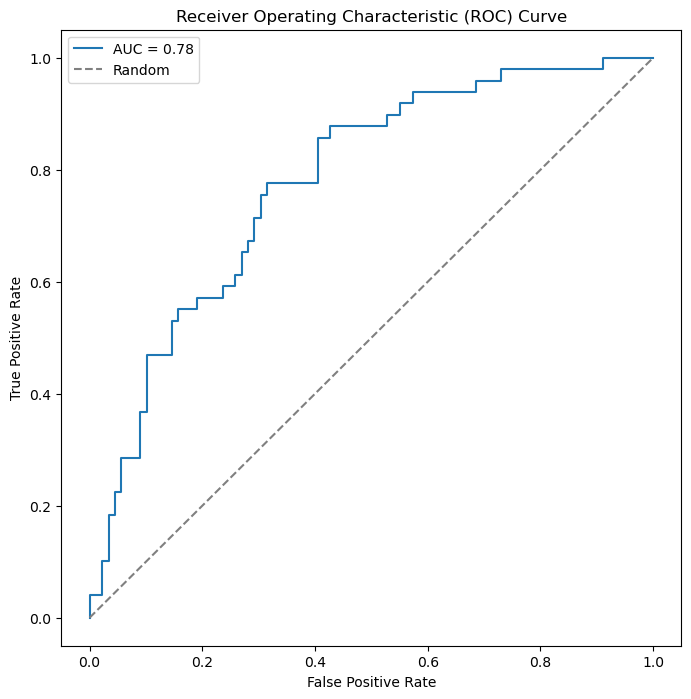

{'Precision': 0.6486486486486487, 'Recall': 0.4897959183673469, 'F1 Score': 0.5581395348837208, 'AUC': 0.7764274249025452}


In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def calculate_classification_metrics(true_labels, predicted_probabilities, threshold=0.5):
    # Convert probabilities to binary predictions based on the threshold
    predicted_labels = [1 if prob >= threshold else 0 for prob in predicted_probabilities]

    # Calculate precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    # Calculate AUC and plot ROC curve
    auc = roc_auc_score(true_labels, predicted_probabilities)
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    # Return metrics
    metrics = {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    }

    return metrics

# Example usage:
true_labels = targets_binarised
predicted_probabilities = tensor_preds_single_col

metrics = calculate_classification_metrics(true_labels, predicted_probabilities)
print(metrics)

In [57]:
from sklearn.metrics import classification_report

preds_binary = [int(i > .5) for i in preds_second_col]

print(classification_report(y_true_binary, preds_binary))

              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80        89
         1.0       0.65      0.49      0.56        49

    accuracy                           0.72       138
   macro avg       0.70      0.67      0.68       138
weighted avg       0.72      0.72      0.71       138



In [9]:
auc_metric(tensor_preds, tensor_y_true)
auc_value = auc_metric.aggregate()
print(auc_value)
auc_metric.reset()

TypeError: 'BinaryAUROC' object is not callable

In [99]:
tensor_preds_binary = [torch.as_tensor(x) for x in preds_binary]
tensor_y_true_binary = [torch.as_tensor(x) for x in y_true_binary]

auc_metric(tensor_preds_binary, tensor_y_true_binary)
auc_value = auc_metric.aggregate()
print(auc_value)
auc_metric.reset()

0.622907590002293


In [108]:
#acc = metrics.f1_score(y_true_binary, preds)
sklearn.metrics.roc_auc_score(y_true_binary, list(df_preds['pred_1']))


0.741343728502637

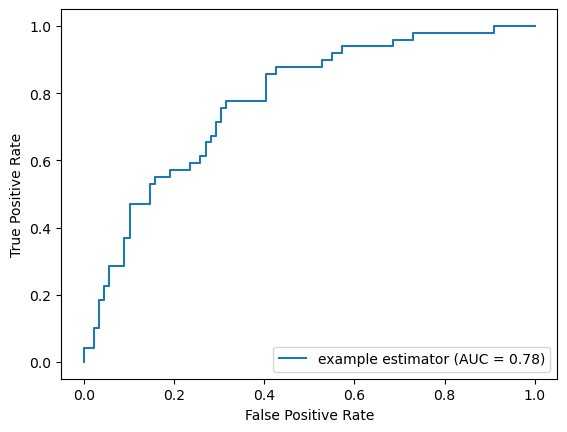

In [96]:

fpr, tpr, thresholds = metrics.roc_curve(y_true_binary, list(df_preds['pred_1']))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

In [150]:
ens_file_dir = "experiments/Xero_DCNN_20240111/20240110_152732_4_9_16_dcnn_lrelu_params_140144_auc_tr_0.782_lr_0.778_val_0.715_lr_0.751_test_0.741_lr_0.752/dcnn_lrelu_ens_outputs.csv"

df_ens_preds = pd.read_csv(ens_file_dir, delimiter=";")
#print(df_preds.head())

ens_preds = [list(row) for row in zip(df_ens_preds['pred_0'], df_ens_preds['pred_1'])]
ens_preds_binary = [1 if p2 > p1 else 0 for [p1,p2] in preds]

ens_y_true = [list(row) for row in zip(df_ens_preds['true_0'], df_ens_preds['true_1'])]
ens_y_true_binary = list(df_ens_preds['true_1'])

metrics.roc_auc_score(ens_y_true_binary, list(df_ens_preds['pred_1']), average='macro')

0.7612932813574869

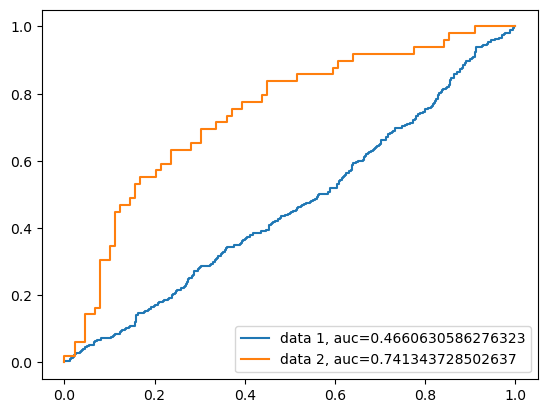

In [106]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_true_binary, list(df_preds['pred_1']))
auc = metrics.roc_auc_score(y_true_binary, list(df_preds['pred_1']))
plt.plot(fpr,tpr,label="data 2, auc="+str(auc))

plt.legend(loc=0)